<a href="https://colab.research.google.com/github/AnanyaBhalla/GC-SAM/blob/main/fine_tune_SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/83tnWs_YBRQ

**This notebook walks you through the process of fine-tuning a Segment Anything Model (SAM) using custom data**.
<p>

**What is SAM?**
<br>
SAM is an image segmentation model developed by Meta AI. It was trained over 11 billion segmentation masks from millions of images. It is designed to take human prompts, in the form of points, bounding boxes or even a text prompt describing what should be segmented.
<p>

**What are the key features of SAM?**
<br>

* **Zero-shot generalization:** SAM can be used to segment objects that it has never seen before, without the need for additional training.

* **Flexible prompting:** SAM can be prompted with a variety of input, including points, boxes, and text descriptions.

* **Real-time mask computation:** SAM can generate masks for objects in real time. This makes SAM ideal for applications where it is necessary to segment objects quickly, such as autonomous driving and robotics.

* **Ambiguity awareness:** SAM is aware of the ambiguity of objects in images. This means that SAM can generate masks for objects even when they are partially occluded or overlapping with other objects.

<p>

**How does SAM work?**
<br>
SAM works by first encoding the image into a high-dimensional vector representation. The prompt is encoded into a separate vector representation. The two vector representations are then combined and passed to a mask decoder, which outputs a mask for the object specified by the prompt.
<p>
The image encoder is a vision transformer (ViT-H) model, which is a large language model that has been pre-trained on a massive dataset of images. The prompt encoder is a simple text encoder that converts the input prompt into a vector representation. The mask decoder is a lightweight transformer model that predicts the object mask from the image and prompt embeddings.
<p>

**SAM paper:** https://arxiv.org/pdf/2304.02643.pdf​
<p>

**Link to the dataset used in this demonstration:** https://www.epfl.ch/labs/cvlab/data/data-em/
<br>Courtesy: EPFL
<p>

This code has been heavily adapted from this notebook but modified to work with a truly custom dataset where we have a bunch of images and binary masks.
https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SAM/Fine_tune_SAM_(segment_anything)_on_a_custom_dataset.ipynb



In [1]:
# If you're using Google Colab, you can mount your folder with the images onto Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-h4eyx3eh
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-h4eyx3eh
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:

import os
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage
from PIL import Image
from transformers import SamModel, SamConfig, SamProcessor
from tqdm import tqdm
from statistics import mean
from datasets import Dataset
import torch
from torch.nn.functional import threshold, normalize
from torch.optim import Adam
import monai
from torch.utils.data import DataLoader
import json
import skimage.draw
import skimage.io
import matplotlib.pyplot as plt

In [34]:
# Folder paths - change the below to True or False depending on the env
google_colab = True

if google_colab:
    #training_img_path = "/content/drive/MyDrive/DinaDL/validation_train_split/train_image"
    training_img_path = "/content/drive/MyDrive/sml/SAM/GC_fine_tuning/training/wsis"
    annotations_path = "/content/drive/MyDrive/sml/SAM/GC_fine_tuning/training/annotations/100cohort"

    #training_mask_path = "/content/drive/MyDrive/DinaDL/validation_train_split/train_mask"
    training_mask_path = "/content/drive/MyDrive/sml/SAM/GC_fine_tuning/training/masks"
    model_checkpoint = "/content/drive/MyDrive/DinaDL/validation_train_split/model_checkpoint.pth"
    test_img_path = "/content/drive/MyDrive/sml/SAM/trial/test_images.tiff"

else:
    training_img_path = "validation_train_split/train_image"
    annotations_path = 'training/annotations/100cohort'
    training_mask_path = "validation_train_split/train_mask"
    model_checkpoint = "model_checkpoint.pth"
    test_img_path = "test_images"


patch_size = 256
step = 256

Pre-processing - convert json annotations to mask images

In [ ]:
def create_mask(image_info, annotations, output_path, output_file_name):
    # Create an empty mask as a numpy array
    mask_np = np.zeros((image_info['height'], image_info['width']), dtype=np.uint16)

    # Counter for the object number
    object_number = 1

    for ann in annotations:
        if ann['type'] == "Feature":
            # Extract segmentation polygon
            for seg in ann['geometry']['coordinates']:
                # Convert polygons to a binary mask and add it to the main mask
                poly = np.array(seg)
                if np.any(poly >= np.array([image_info['width'], image_info['height']])) or np.any(poly < 0):
                    print(f"Polygon coordinates out of bounds in {output_file_name}")
                    continue
                rr, cc = skimage.draw.polygon(poly[:, 1], poly[:, 0], mask_np.shape)
                mask_np[rr, cc] = object_number
                object_number += 1 # We are assigning each object a unique integer value (labeled mask)

    # Debug: Print non-zero values in the mask
    non_zero_values = np.count_nonzero(mask_np)
    print(f"Non-zero values in the mask for {output_file_name}: {non_zero_values}")

    # Save the numpy array as a PNG file
    mask_path = os.path.join(output_path, output_file_name.replace('.json', '.png'))
    skimage.io.imsave(mask_path, mask_np)

    print(f"Saved mask for {output_file_name} to {mask_path}")

def load_json_annotations(annotations_path, mask_output_path, training_img_path):
    # Ensure the output directories exist
    if not os.path.exists(mask_output_path):
        os.makedirs(mask_output_path)

    # Iterate through all JSON files in the annotations folder
    for json_file in os.listdir(annotations_path):
        if json_file.endswith('.json'):
            json_path = os.path.join(annotations_path, json_file)
            # Load JSON annotations
            with open(json_path, 'r') as f:
                data = json.load(f)

            annotations = data

            # Find the corresponding image file
            image_file = os.path.join(training_img_path, json_file.replace('.json', '.png'))
            if os.path.exists(image_file):
                image = skimage.io.imread(image_file)
                height, width = image.shape[:2]

                # Create the image_info dictionary
                image_info = {
                    'id': json_file.replace('.json', ''),
                    'file_name': json_file.replace('.json', '.png'),
                    'height': height,
                    'width': width
                }

                # Create the masks for the given image info
                create_mask(image_info, annotations, mask_output_path, json_file)
            else:
                print(f"Image file {image_file} not found. Skipping.")

# Create masks from annotations
load_json_annotations(annotations_path, training_mask_path, training_img_path)

Now. let us divide these large images into smaller patches for training. We can use patchify or write custom code.

In [35]:
def match_image_and_mask_filenames(image_folder, mask_folder):
    image_filenames = []
    mask_filenames = []

    for filename in os.listdir(image_folder):
        if filename.endswith(".png") or filename.endswith(".jpg") or filename.endswith(".tiff") or filename.endswith(".tif"):
            image_filenames.append(filename)

    for filename in os.listdir(mask_folder):
        if filename.endswith(".png") or filename.endswith(".jpg") or filename.endswith(".tiff") or filename.endswith(".tif"):
            mask_filenames.append(filename)

    matched_pairs = []
    for image_filename in image_filenames:
        # Find the corresponding mask filename
        base_name = image_filename.split('_TRAIN_image')[0]
        mask_filename = base_name + '__TRAIN_masked.png'

        if mask_filename in mask_filenames:
            matched_pairs.append((image_filename, mask_filename))

    return matched_pairs

def convert_to_rgb(image):
    """
    Converts a grayscale image to RGB by duplicating the single channel across three channels.

    Args:
        image (PIL.Image): The input grayscale image.

    Returns:
        PIL.Image: The converted RGB image.
    """
    if image.mode == 'L':  # Check if the image is grayscale
        image = np.array(image)
        image = np.stack((image,) * 3, axis=-1)  # Duplicate the single channel across three channels
        image = Image.fromarray(image, mode='RGB')
    return image

def load_and_patchify_images_and_masks(image_folder, mask_folder, patch_size, step):
    images = []
    masks = []
    matched_pairs = match_image_and_mask_filenames(image_folder, mask_folder)

    for image_filename, mask_filename in matched_pairs:
        # Load and patchify image
        img_path = os.path.join(image_folder, image_filename)
        if img_path.endswith(".png") or img_path.endswith(".jpg"):
            img = Image.open(img_path)
            img = convert_to_rgb(img)  # Convert to RGB if grayscale
            img = np.array(img)
        elif img_path.endswith(".tiff") or img_path.endswith(".tif"):
            img = tifffile.imread(img_path)
            if img.ndim == 2:  # If the TIFF image is grayscale
                img = np.stack((img,) * 3, axis=-1)  # Convert to RGB
            elif img.ndim == 3 and img.shape[2] == 1:  # If the TIFF image is single channel
                img = np.squeeze(img, axis=2)
                img = np.stack((img,) * 3, axis=-1)  # Convert to RGB
        else:
            continue

        patches_img = patchify(img, (patch_size, patch_size, 3), step=step)  # Ensure RGB output
        patches_img = patches_img.reshape(-1, patch_size, patch_size, 3)  # Reshape to remove singleton dimensions
        images.extend(patches_img)

        # Load and patchify mask
        mask_path = os.path.join(mask_folder, mask_filename)
        if mask_path.endswith(".png") or mask_path.endswith(".jpg"):
            mask = Image.open(mask_path).convert("L")
            mask = np.array(mask)
        elif mask_path.endswith(".tiff") or mask_path.endswith(".tif"):
            mask = tifffile.imread(mask_path)
            if mask.ndim == 3 and mask.shape[2] == 1:
                mask = np.squeeze(mask, axis=2)
        else:
            continue

        mask = np.expand_dims(mask, axis=-1)  # Ensure mask has a channel dimension

        patches_mask = patchify(mask, (patch_size, patch_size, 1), step=step)  # Assume single-channel mask
        patches_mask = patches_mask.reshape(-1, patch_size, patch_size, 1)  # Reshape to remove singleton dimensions
        masks.extend(patches_mask)

    return np.array(images), np.array(masks)

# Load and patchify images and masks
images, masks = load_and_patchify_images_and_masks(training_img_path, training_mask_path, patch_size, step)
print(f"Image patches shape: {images.shape}")
print(f"Mask patches shape: {masks.shape}")

Image patches shape: (5348, 256, 256, 3)
Mask patches shape: (5348, 256, 256, 1)


Now, let us delete empty masks as they may cause issues later on during training. If a batch contains empty masks then the loss function will throw an error as it may not know how to handle empty tensors.

In [36]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

Image shape: (2992, 256, 256, 3)
Mask shape: (2992, 256, 256, 1)


Let us create a 'dataset' that serves us input images and masks for the rest of our journey.

In [37]:
# Convert the NumPy arrays to Pillow images and preprocess them
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask.squeeze()) for mask in filtered_masks],  # Use squeeze to remove the singleton dimension
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [38]:
# Function to print the number of channels in the first image
def print_number_of_channels(dataset):
    if len(dataset) > 0:
        item = dataset[0]
        image = item['image']
        # Convert to NumPy array if necessary
        if isinstance(image, Image.Image):
            image = np.array(image)
        num_channels = image.shape[-1] if image.ndim == 3 else 1
        print(f"The first image has {num_channels} channel(s)")
    else:
        print("The dataset is empty")

# Print the number of channels for the first image in the dataset
print_number_of_channels(dataset)

The first image has 3 channel(s)


In [39]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 2992
})

Let us make sure out images and masks (labels) are loading appropriately

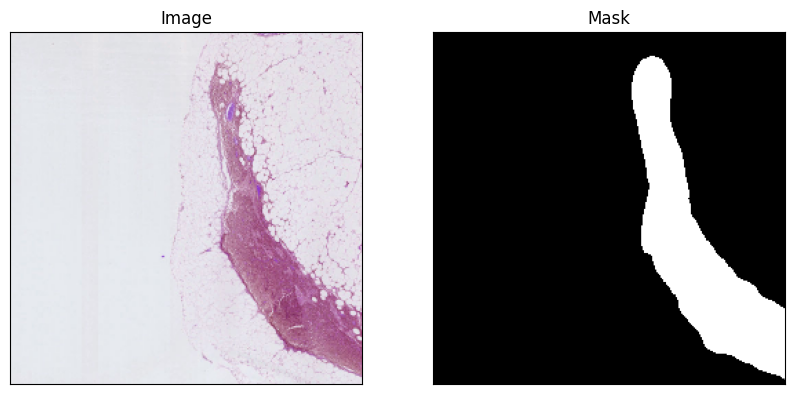

In [40]:
img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

Get bounding boxes from masks. You can get here directly if you are working with coco style annotations where bounding boxes are captured in a JSON file.

In [41]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [42]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [43]:
# Initialize the processor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [44]:
# Create a DataLoader instance for the training dataset
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [45]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [46]:
# Load the model
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [47]:
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [48]:
#Training loop
num_epochs = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 1496/1496 [24:12<00:00,  1.03it/s]

EPOCH: 0
Mean loss: -2094053.1169222333


In [49]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), model_checkpoint)

**Inference**

In [ ]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
#my_mito_model.load_state_dict(torch.load("first_model_checkpoint.pth"))
# Colab version
my_mito_model.load_state_dict(torch.load(model_checkpoint))

In [ ]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

In [ ]:
# let's take a random training example
idx = random.randint(0, filtered_images.shape[0]-1)

# load image
test_image = dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()


Now, let us load a new image and segment it using our trained model. NOte that we need to provide some prompt. Since we do not know where the objects are going to be we cannot supply bounding boxes. So let us provide a grid of points as our prompt.

In [ ]:
#Apply a trained model on large image
#large_test_images = tifffile.imread("test_images.tiff")
#Colab version
large_test_images = tifffile.imread(test_img_path)

large_test_image = large_test_images[1]
patches = patchify(large_test_image, (256, 256), step=256)  #Step=256 for 256 patches means no overlap

In [ ]:
"""
input_points (torch.FloatTensor of shape (batch_size, num_points, 2)) —
Input 2D spatial points, this is used by the prompt encoder to encode the prompt.
Generally yields to much better results. The points can be obtained by passing a
list of list of list to the processor that will create corresponding torch tensors
of dimension 4. The first dimension is the image batch size, the second dimension
is the point batch size (i.e. how many segmentation masks do we want the model to
predict per input point), the third dimension is the number of points per segmentation
mask (it is possible to pass multiple points for a single mask), and the last dimension
is the x (vertical) and y (horizontal) coordinates of the point. If a different number
of points is passed either for each image, or for each mask, the processor will create
“PAD” points that will correspond to the (0, 0) coordinate, and the computation of the
embedding will be skipped for these points using the labels.

"""
# Define the size of your array
array_size = 256

# Define the size of your grid
grid_size = 10

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

#We need to reshape our nxn grid to the expected shape of the input_points tensor
# (batch_size, point_batch_size, num_points_per_image, 2),
# where the last dimension of 2 represents the x and y coordinates of each point.
#batch_size: The number of images you're processing at once.
#point_batch_size: The number of point sets you have for each image.
#num_points_per_image: The number of points in each set.
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)

In [ ]:
print(np.array(input_points).shape)

In [ ]:
patches.shape

In [ ]:
# Select a random patch for segmentation

# Compute the total number of 256x256 arrays
#num_arrays = patches.shape[0] * patches.shape[1]
# Select a random index
#index = np.random.choice(num_arrays)
# Compute the indices in the original array
#i = index // patches.shape[1]
#j = index % patches.shape[1]

#Or pick a specific patch for study.
i, j = 1, 2

# Selected patch for segmentation
random_array = patches[i, j]

single_patch = Image.fromarray(random_array)
# prepare image for the model

# Check and reshape the single_patch to have 3 dimensions
if single_patch.mode == 'L':  # If it's a grayscale image
    single_patch = np.array(single_patch)
    single_patch = np.expand_dims(single_patch, axis=-1)  # Expand dimensions to (height, width, 1)
    single_patch = np.concatenate([single_patch] * 3, axis=-1)  # Duplicate the channel to get (height, width, 3)

# Convert the array back to PIL Image for the processor
single_patch = Image.fromarray(np.uint8(single_patch))


#First try without providing any prompt (no bounding box or input_points)
#inputs = processor(single_patch, return_tensors="pt")
#Now try with bounding boxes. Remember to uncomment.
inputs = processor(single_patch, input_points=input_points, return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}
my_mito_model.eval()


# forward pass
with torch.no_grad():
  outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
single_patch_prediction = (single_patch_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(single_patch), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(single_patch_prob)  # Assuming the second image is grayscale
axes[1].set_title("Probability Map")

# Plot the second image on the right
axes[2].imshow(single_patch_prediction, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Prediction")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()